# WGCNA
weighted gene co-expression network analysis

# Phase 2 vs. Phase 2

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu)

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [5]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 94 samples x 35466 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111133554,LOC111125466,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_B1_O01,7.692872,10.197580,8.354765,7.886383,9.363550,7.548551,7.548551,7.692872,7.548551,7.650623,⋯,18.94773,17.35567,16.72734,16.55278,17.40296,17.50511,15.27334,14.40950,17.08613,13.21049
B1_W5_O50,7.805746,9.653169,8.542687,7.697174,9.355360,7.548551,7.548551,7.845404,7.548551,7.548551,⋯,19.25087,17.60046,17.05547,16.54477,16.97662,17.30129,15.59674,14.95796,17.21506,13.41728
B2_B5_O51,7.871959,9.900281,8.351593,7.548551,9.509373,7.548551,7.548551,8.595408,7.548551,7.651014,⋯,19.41971,17.94342,17.27196,17.23549,17.79404,18.11808,15.98559,15.64247,17.74181,13.77409
B2_C4_O40,7.843091,9.718856,8.513945,7.687586,9.284512,7.548551,7.548551,8.101515,7.843091,7.548551,⋯,18.86611,17.79882,17.27281,16.61824,17.19524,17.19285,15.14694,14.83363,17.01083,13.11047
B3_B4_O41,7.548551,9.612738,8.518601,7.940109,9.198871,7.548551,7.548551,8.014009,7.548551,7.661902,⋯,19.71514,18.17021,17.54836,17.11674,17.49138,17.97654,15.71235,15.28878,17.71717,13.87237
B3_C3_O30,7.909124,9.545333,8.653091,7.989592,9.337765,7.548551,7.710140,8.149132,7.828140,7.926626,⋯,19.27273,17.87689,17.64807,17.08072,17.29751,17.13546,15.58747,15.14063,17.14174,13.28853


[1]    94 35466

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [6]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 70 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    94 35396

### C. Sample size and gene filtering

removing low-variance genes first:

In [7]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 94 samples x 26547 genes

[1]    94 26547

### D. Sample outlier detection

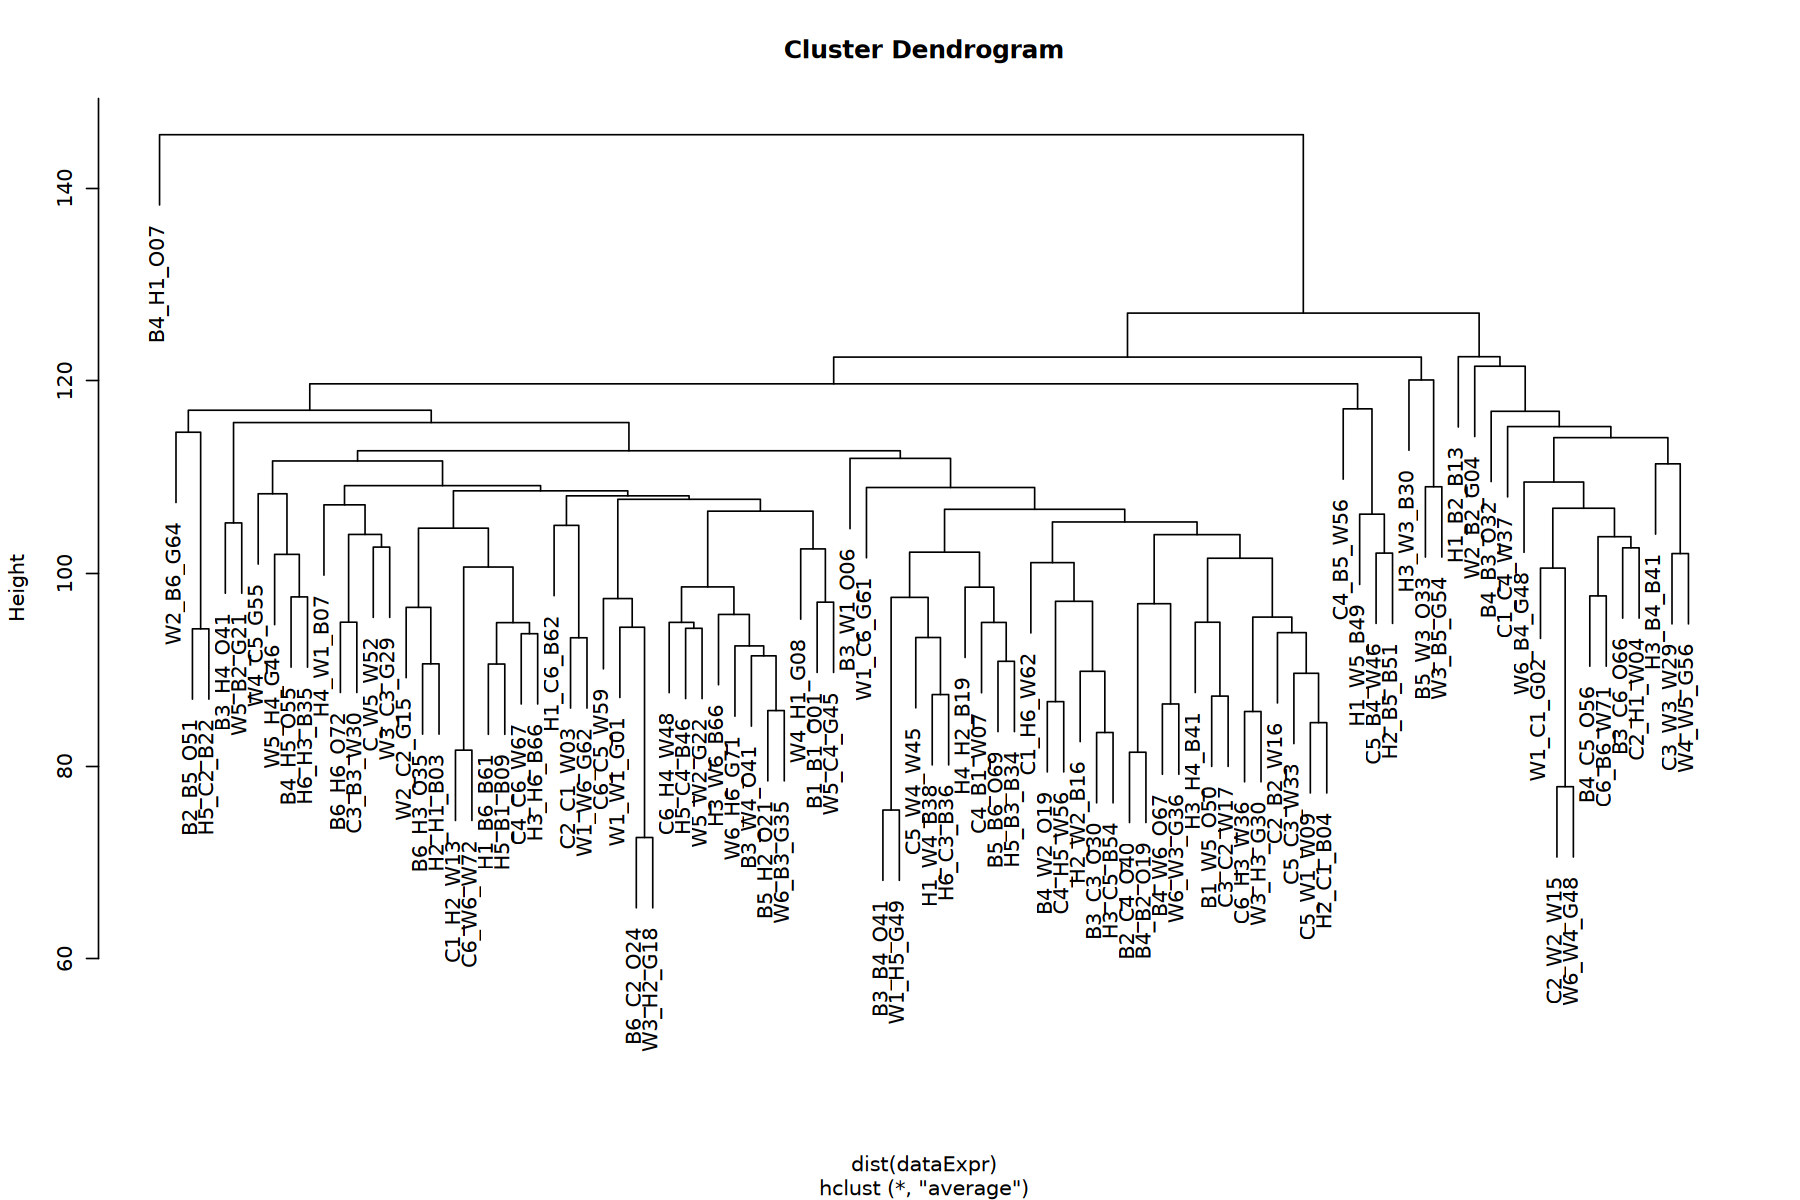

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

In [9]:
dataExpr <- dataExpr[!rownames(dataExpr) %in% c("B4_H1_O07"), ]
dim(dataExpr) # 93 samples x 26547 genes

[1]    93 26547

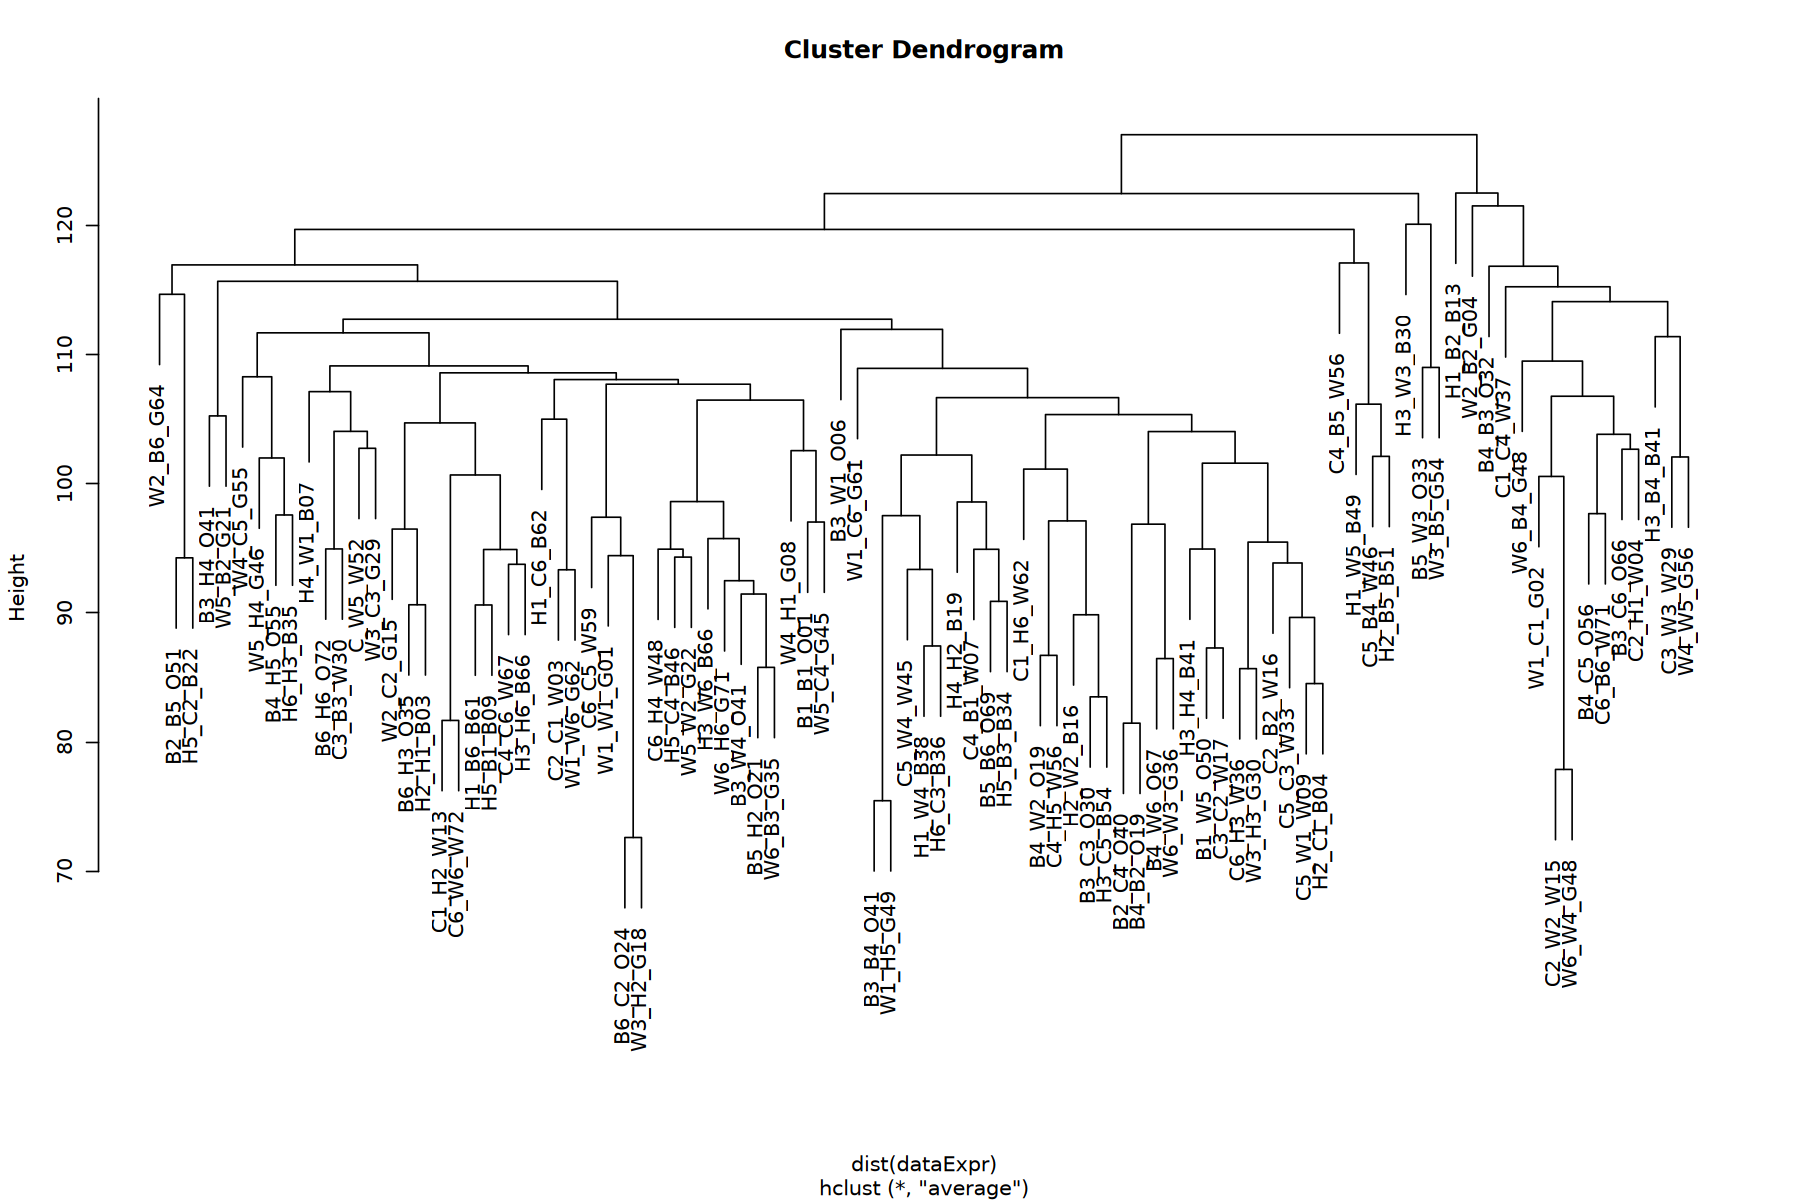

In [10]:
# replot without outliers
sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

looks much better!

### meta data
could add phenotypic data to this ...

In [11]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3


[1] 93  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [12]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

In [13]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [14]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [15]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1685.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1685 of 26547
   ..working on genes 1686 through 3370 of 26547
   ..working on genes 3371 through 5055 of 26547
   ..working on genes 5056 through 6740 of 26547
   ..working on genes 6741 through 8425 of 26547
   ..working on genes 8426 through 10110 of 26547
   ..working on genes 10111 through 11795 of 26547
   ..working on genes 11796 through 13480 of 26547
   ..working on genes 13481 through 15165 of 26547
   ..working on genes 15166 through 16850 of 26547
   ..working on genes 16851 through 18535 of 26547
   ..working on genes 18536 through 20220 of 26547
   ..working on genes 20221 through 21905 of 26547
   ..working on genes 21906 through 23590 of 26547
   ..working on genes 23591 through 25275 of 26547
   ..working on genes 25276 through 26547 of 26547
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.0177 -12.

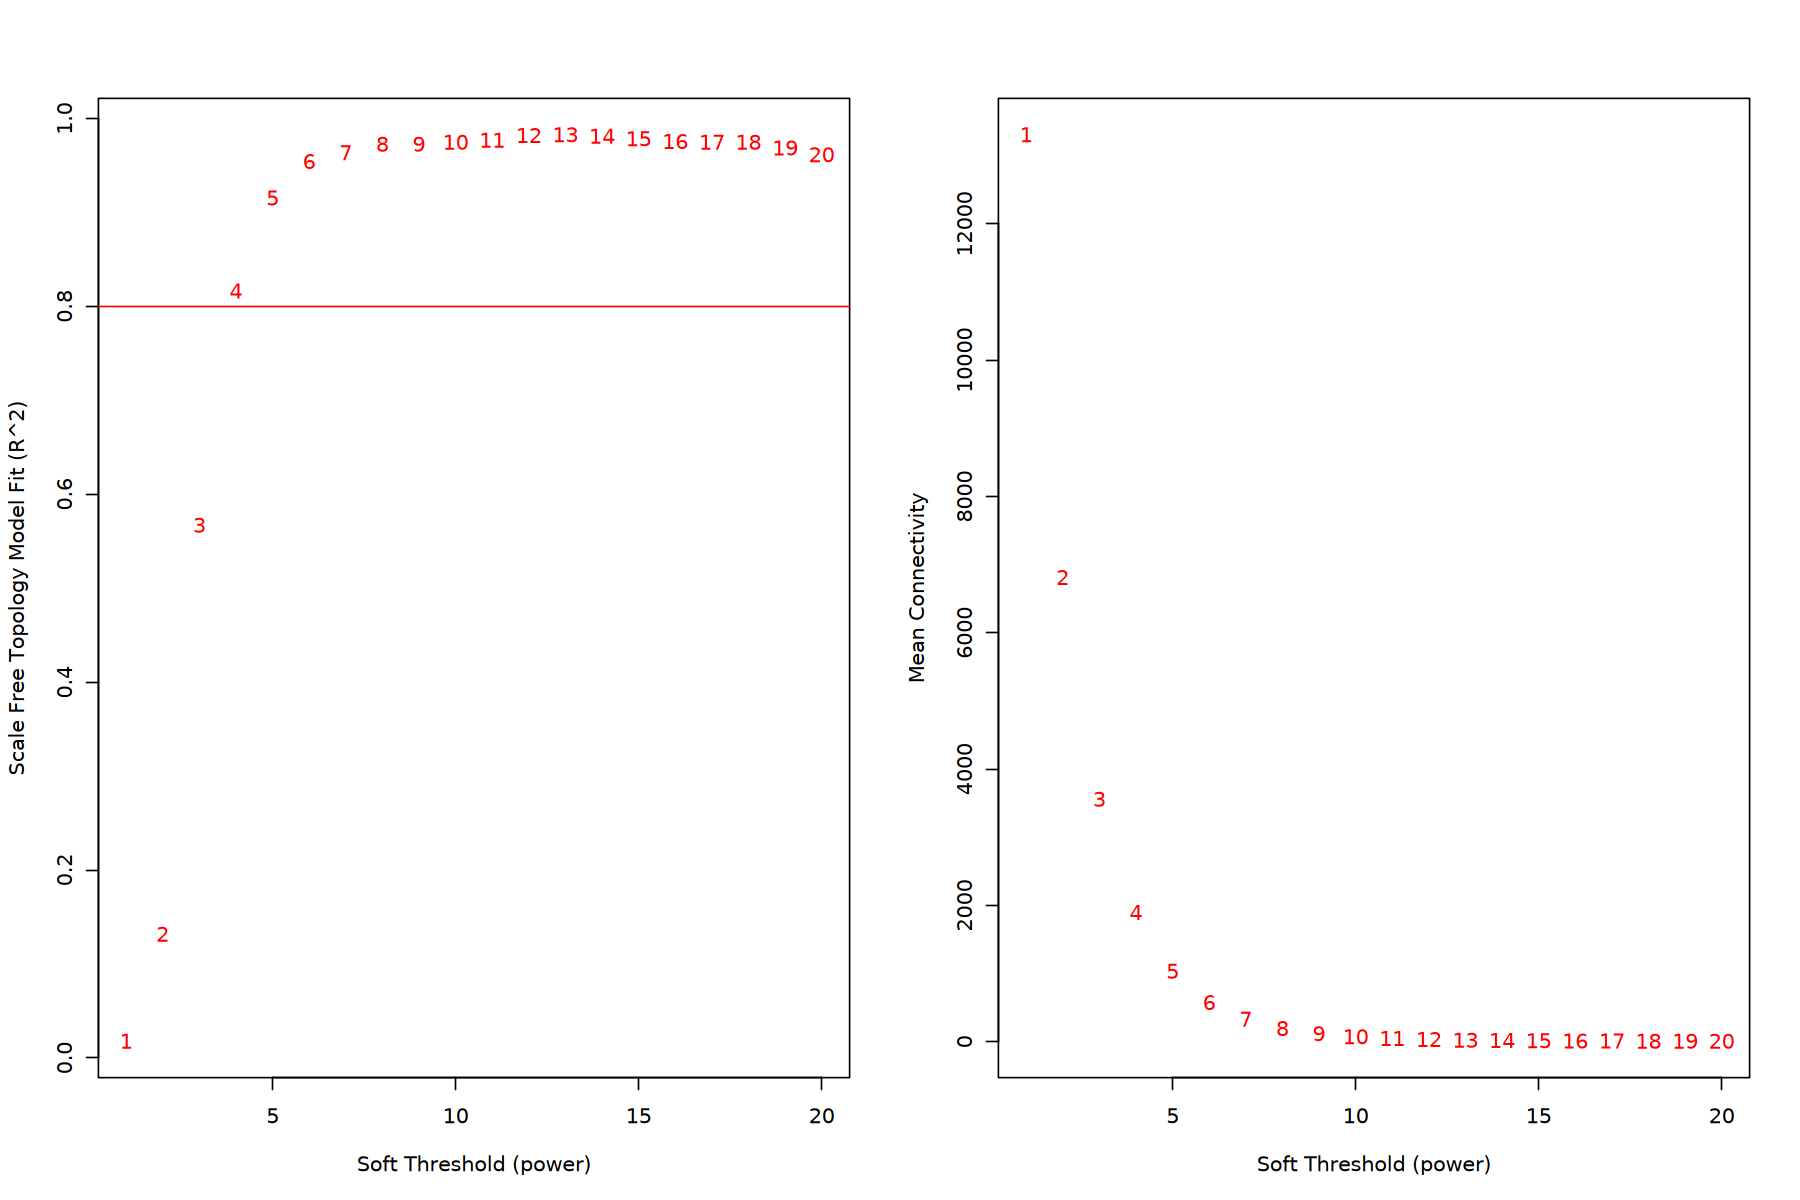

In [16]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 4 is just above 0.8 and anything after 6 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 5 should be appropriate

### B. co-expression similarity and adjacency

creating adjacency matrix

In [17]:
softPower <- 5

calculate co-expression adjacency using soft threshold power of 5

can do this signed or unsigned (default) - at this point, I'm not too sure what the difference is

In [18]:
# unsigned
adjacency_unsign <- adjacency(dataExpr, power = softPower, type = 'unsigned') 
head(adjacency_unsign)

# signed
adjacency_sign <- adjacency(dataExpr, power = softPower, type = 'signed') 
head(adjacency_sign)

,LOC111126949,LOC111120752,LOC111105691,LOC111113860,LOC111109550,LOC111109753,LOC111109452,LOC111124802,LOC111101273,LOC111101250,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
LOC111126949,1.000000e+00,1.782543e-03,2.752219e-08,4.600205e-07,9.155717e-05,1.656267e-05,8.391595e-13,2.581975e-03,1.319233e-02,4.230721e-05,⋯,7.160573e-07,1.558930e-05,5.919973e-06,1.493077e-04,2.374682e-09,5.391527e-09,5.879192e-05,1.105667e-08,2.965007e-06,6.959330e-07
LOC111120752,1.782543e-03,1.000000e+00,1.716104e-06,3.146263e-08,7.358584e-05,1.762023e-09,1.690230e-05,1.070843e-05,3.894397e-02,1.183032e-05,⋯,8.026964e-03,6.595698e-03,1.598050e-02,4.779981e-03,3.795156e-02,4.617818e-03,2.676368e-02,1.774048e-02,1.566690e-02,1.381881e-02
LOC111105691,2.752219e-08,1.716104e-06,1.000000e+00,1.084102e-06,1.915999e-05,2.407908e-07,6.601852e-07,6.362332e-11,5.738142e-08,2.303477e-04,⋯,2.204940e-04,1.582523e-08,5.902503e-10,4.193395e-08,1.465177e-06,4.447607e-05,2.631513e-11,1.409498e-07,1.039271e-05,2.704959e-09
LOC111113860,4.600205e-07,3.146263e-08,1.084102e-06,1.000000e+00,2.333026e-05,8.882854e-06,3.091483e-04,1.303715e-07,1.645528e-07,5.683632e-07,⋯,6.034621e-06,4.048877e-04,1.244493e-03,1.803356e-04,7.549985e-06,2.280600e-06,6.601983e-04,4.168502e-05,2.332036e-04,4.252386e-04
LOC111109550,9.155717e-05,7.358584e-05,1.915999e-05,2.333026e-05,1.000000e+00,4.656518e-06,4.186890e-08,2.371397e-05,2.300438e-07,1.194374e-06,⋯,6.849831e-15,2.213905e-04,7.697647e-08,7.936029e-06,4.187663e-07,8.517485e-10,7.454661e-10,5.411355e-08,1.497762e-07,1.762907e-14
LOC111109753,1.656267e-05,1.762023e-09,2.407908e-07,8.882854e-06,4.656518e-06,1.000000e+00,2.298499e-08,2.020960e-04,8.740811e-04,2.179421e-08,⋯,3.920238e-05,1.177167e-06,4.570454e-16,3.930212e-07,8.284044e-07,1.910615e-04,1.535774e-07,4.270411e-05,1.626405e-04,1.795192e-05


,LOC111126949,LOC111120752,LOC111105691,LOC111113860,LOC111109550,LOC111109753,LOC111109452,LOC111124802,LOC111101273,LOC111101250,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
LOC111126949,1.00000000,0.00596421,0.02673096,0.02367334,0.06443312,0.05280483,0.03185524,0.11767250,0.002037204,0.01527023,⋯,0.04162633,0.017520275,0.019496087,0.01218261,0.02841485,0.03487613,0.014487059,0.02744560,0.04558078,0.041560431
LOC111120752,0.00596421,1.00000000,0.02170610,0.03650792,0.06259823,0.02857326,0.05291190,0.05064454,0.255646300,0.01810499,⋯,0.15696330,0.148799263,0.191643328,0.13676826,0.25339540,0.13556982,0.225477159,0.19787840,0.19049290,0.183436092
LOC111105691,0.02673096,0.02170610,1.00000000,0.04263922,0.05358685,0.03940373,0.02317122,0.02984845,0.037227386,0.01108081,⋯,0.01119240,0.035795722,0.029084096,0.03683972,0.02196268,0.01515245,0.032464819,0.03850535,0.01837367,0.028342929
LOC111113860,0.02367334,0.03650792,0.04263922,1.00000000,0.05469640,0.01869409,0.01032832,0.02521879,0.038753608,0.02338274,⋯,0.01945904,0.009637944,0.006821705,0.01170431,0.01901998,0.02123009,0.008394532,0.01530505,0.01104935,0.009512618
LOC111109550,0.06443312,0.06259823,0.05358685,0.05469640,1.00000000,0.04716812,0.03683787,0.05479113,0.024561187,0.02228596,⋯,0.03102108,0.011182048,0.037616489,0.01892067,0.04045961,0.03372294,0.028983659,0.03715280,0.03860167,0.030973609
LOC111109753,0.05280483,0.02857326,0.03940373,0.01869409,0.04716812,1.00000000,0.02688139,0.07223356,0.007690798,0.02692491,⋯,0.05793885,0.042853010,0.031116627,0.04033135,0.04197053,0.07161344,0.038641818,0.05852193,0.06989560,0.053233270


### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [19]:
## UNSIGNED
# turn adjacency into topological overlap
TOM_unsign <- TOMsimilarity(adjacency_unsign)
head(TOM_unsign)

# calculate dissimilarity
dissTOM_unsign <- 1-TOM_unsign
head(dissTOM_unsign)


## SIGNED
# turn adjacency into topological overlap
TOM_sign <- TOMsimilarity(adjacency_sign)
head(TOM_sign)

# calculate dissimilarity
dissTOM_sign <- 1-TOM_sign
head(dissTOM_sign)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


1.0000000000,0.0042933083,1.852709e-04,5.818304e-04,0.0005404566,0.0003144408,0.0005682741,0.0020470717,0.0071768146,0.0037048014,⋯,0.0004408250,0.0005759230,0.0005677051,0.0004982259,0.0008827370,0.0003837645,0.0007463244,0.0005814072,0.0006610943,0.0004647112
0.0042933083,1.0000000000,2.773913e-04,1.873669e-03,0.0004478330,0.0001914498,0.0012254369,0.0010705347,0.0226939637,0.0030848120,⋯,0.0164825038,0.0195005626,0.0236828804,0.0198913808,0.0231048502,0.0120065692,0.0230095491,0.0235759301,0.0164464391,0.0184666636
0.0001852709,0.0002773913,1.000000e+00,5.565506e-05,0.0001184485,0.0002327076,0.0001395993,0.0001562924,0.0001999636,0.0007183777,⋯,0.0003600078,0.0001663546,0.0001553802,0.0001165873,0.0002603584,0.0002545397,0.0002055112,0.0002058637,0.0003232873,0.0001910332
0.0005818304,0.0018736690,5.565506e-05,1.000000e+00,0.0001005873,0.0001449656,0.0014757616,0.0003609820,0.0011261494,0.0016916643,⋯,0.0005621569,0.0006108221,0.0007841932,0.0004435304,0.0007163779,0.0004381356,0.0010218126,0.0006395913,0.0008489379,0.0006412816
0.0005404566,0.0004478330,1.184485e-04,1.005873e-04,1.0000000000,0.0003099846,0.0001955092,0.0004039726,0.0003043675,0.0003599073,⋯,0.0002965254,0.0003927036,0.0002604835,0.0001557174,0.0003543204,0.0002128943,0.0003100519,0.0003067601,0.0003578739,0.0002432699
0.0003144408,0.0001914498,2.327076e-04,1.449656e-04,0.0003099846,1.0000000000,0.0001828311,0.0004006687,0.0004618206,0.0001673186,⋯,0.0008082062,0.0004760549,0.0001727626,0.0003480783,0.0003218440,0.0011239916,0.0002740738,0.0007224079,0.0027691623,0.0018399482


0.0000000,0.9957067,0.9998147,0.9994182,0.9994595,0.9996856,0.9994317,0.9979529,0.9928232,0.9962952,⋯,0.9995592,0.9994241,0.9994323,0.9995018,0.9991173,0.9996162,0.9992537,0.9994186,0.9993389,0.9995353
0.9957067,0.0000000,0.9997226,0.9981263,0.9995522,0.9998086,0.9987746,0.9989295,0.9773060,0.9969152,⋯,0.9835175,0.9804994,0.9763171,0.9801086,0.9768951,0.9879934,0.9769905,0.9764241,0.9835536,0.9815333
0.9998147,0.9997226,0.0000000,0.9999443,0.9998816,0.9997673,0.9998604,0.9998437,0.9998000,0.9992816,⋯,0.9996400,0.9998336,0.9998446,0.9998834,0.9997396,0.9997455,0.9997945,0.9997941,0.9996767,0.9998090
0.9994182,0.9981263,0.9999443,0.0000000,0.9998994,0.9998550,0.9985242,0.9996390,0.9988739,0.9983083,⋯,0.9994378,0.9993892,0.9992158,0.9995565,0.9992836,0.9995619,0.9989782,0.9993604,0.9991511,0.9993587
0.9994595,0.9995522,0.9998816,0.9998994,0.0000000,0.9996900,0.9998045,0.9995960,0.9996956,0.9996401,⋯,0.9997035,0.9996073,0.9997395,0.9998443,0.9996457,0.9997871,0.9996899,0.9996932,0.9996421,0.9997567
0.9996856,0.9998086,0.9997673,0.9998550,0.9996900,0.0000000,0.9998172,0.9995993,0.9995382,0.9998327,⋯,0.9991918,0.9995239,0.9998272,0.9996519,0.9996782,0.9988760,0.9997259,0.9992776,0.9972308,0.9981601


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


1.00000000,0.03203669,0.04325609,0.03859603,0.04767874,0.04841777,0.04451317,0.05394023,0.02788190,0.03691653,⋯,0.04095883,0.03843461,0.03899431,0.03807728,0.04075141,0.04319353,0.03923952,0.04058928,0.04422606,0.04232475
0.03203669,1.00000000,0.04151904,0.04947939,0.04474896,0.04240832,0.04069907,0.04546719,0.07603718,0.03576878,⋯,0.06625035,0.06621622,0.06956860,0.06530790,0.07331335,0.06192108,0.06849582,0.06912506,0.07022219,0.06638767
0.04325609,0.04151904,1.00000000,0.03602860,0.03812489,0.04259115,0.03941299,0.04030782,0.03924153,0.03933737,⋯,0.04050891,0.04099153,0.04117581,0.04055060,0.04217482,0.03939417,0.04255275,0.04350582,0.04239243,0.04209052
0.03859603,0.04947939,0.03602860,1.00000000,0.03793008,0.04057033,0.03429513,0.03711149,0.04525296,0.04092677,⋯,0.04474596,0.04012829,0.03969172,0.04049417,0.04444097,0.04076944,0.03947218,0.04203759,0.04310102,0.04108138
0.04767874,0.04474896,0.03812489,0.03793008,1.00000000,0.04515372,0.03986899,0.04416545,0.03677512,0.04383935,⋯,0.04130757,0.03881138,0.04178284,0.03773336,0.04446496,0.04154167,0.04249430,0.04248601,0.04382650,0.04165347
0.04841777,0.04240832,0.04259115,0.04057033,0.04515372,1.00000000,0.04496422,0.05007689,0.03452615,0.04054339,⋯,0.05118587,0.04825489,0.04445493,0.04639658,0.04698003,0.05398672,0.04633184,0.05064223,0.05719088,0.05367676


0.0000000,0.9679633,0.9567439,0.9614040,0.9523213,0.9515822,0.9554868,0.9460598,0.9721181,0.9630835,⋯,0.9590412,0.9615654,0.9610057,0.9619227,0.9592486,0.9568065,0.9607605,0.9594107,0.9557739,0.9576752
0.9679633,0.0000000,0.9584810,0.9505206,0.9552510,0.9575917,0.9593009,0.9545328,0.9239628,0.9642312,⋯,0.9337496,0.9337838,0.9304314,0.9346921,0.9266867,0.9380789,0.9315042,0.9308749,0.9297778,0.9336123
0.9567439,0.9584810,0.0000000,0.9639714,0.9618751,0.9574089,0.9605870,0.9596922,0.9607585,0.9606626,⋯,0.9594911,0.9590085,0.9588242,0.9594494,0.9578252,0.9606058,0.9574472,0.9564942,0.9576076,0.9579095
0.9614040,0.9505206,0.9639714,0.0000000,0.9620699,0.9594297,0.9657049,0.9628885,0.9547470,0.9590732,⋯,0.9552540,0.9598717,0.9603083,0.9595058,0.9555590,0.9592306,0.9605278,0.9579624,0.9568990,0.9589186
0.9523213,0.9552510,0.9618751,0.9620699,0.0000000,0.9548463,0.9601310,0.9558345,0.9632249,0.9561606,⋯,0.9586924,0.9611886,0.9582172,0.9622666,0.9555350,0.9584583,0.9575057,0.9575140,0.9561735,0.9583465
0.9515822,0.9575917,0.9574089,0.9594297,0.9548463,0.0000000,0.9550358,0.9499231,0.9654738,0.9594566,⋯,0.9488141,0.9517451,0.9555451,0.9536034,0.9530200,0.9460133,0.9536682,0.9493578,0.9428091,0.9463232


### D. Call the hierarchical clustering function - plot the tree
hierarchical clustering tree (dendrogram) of genes

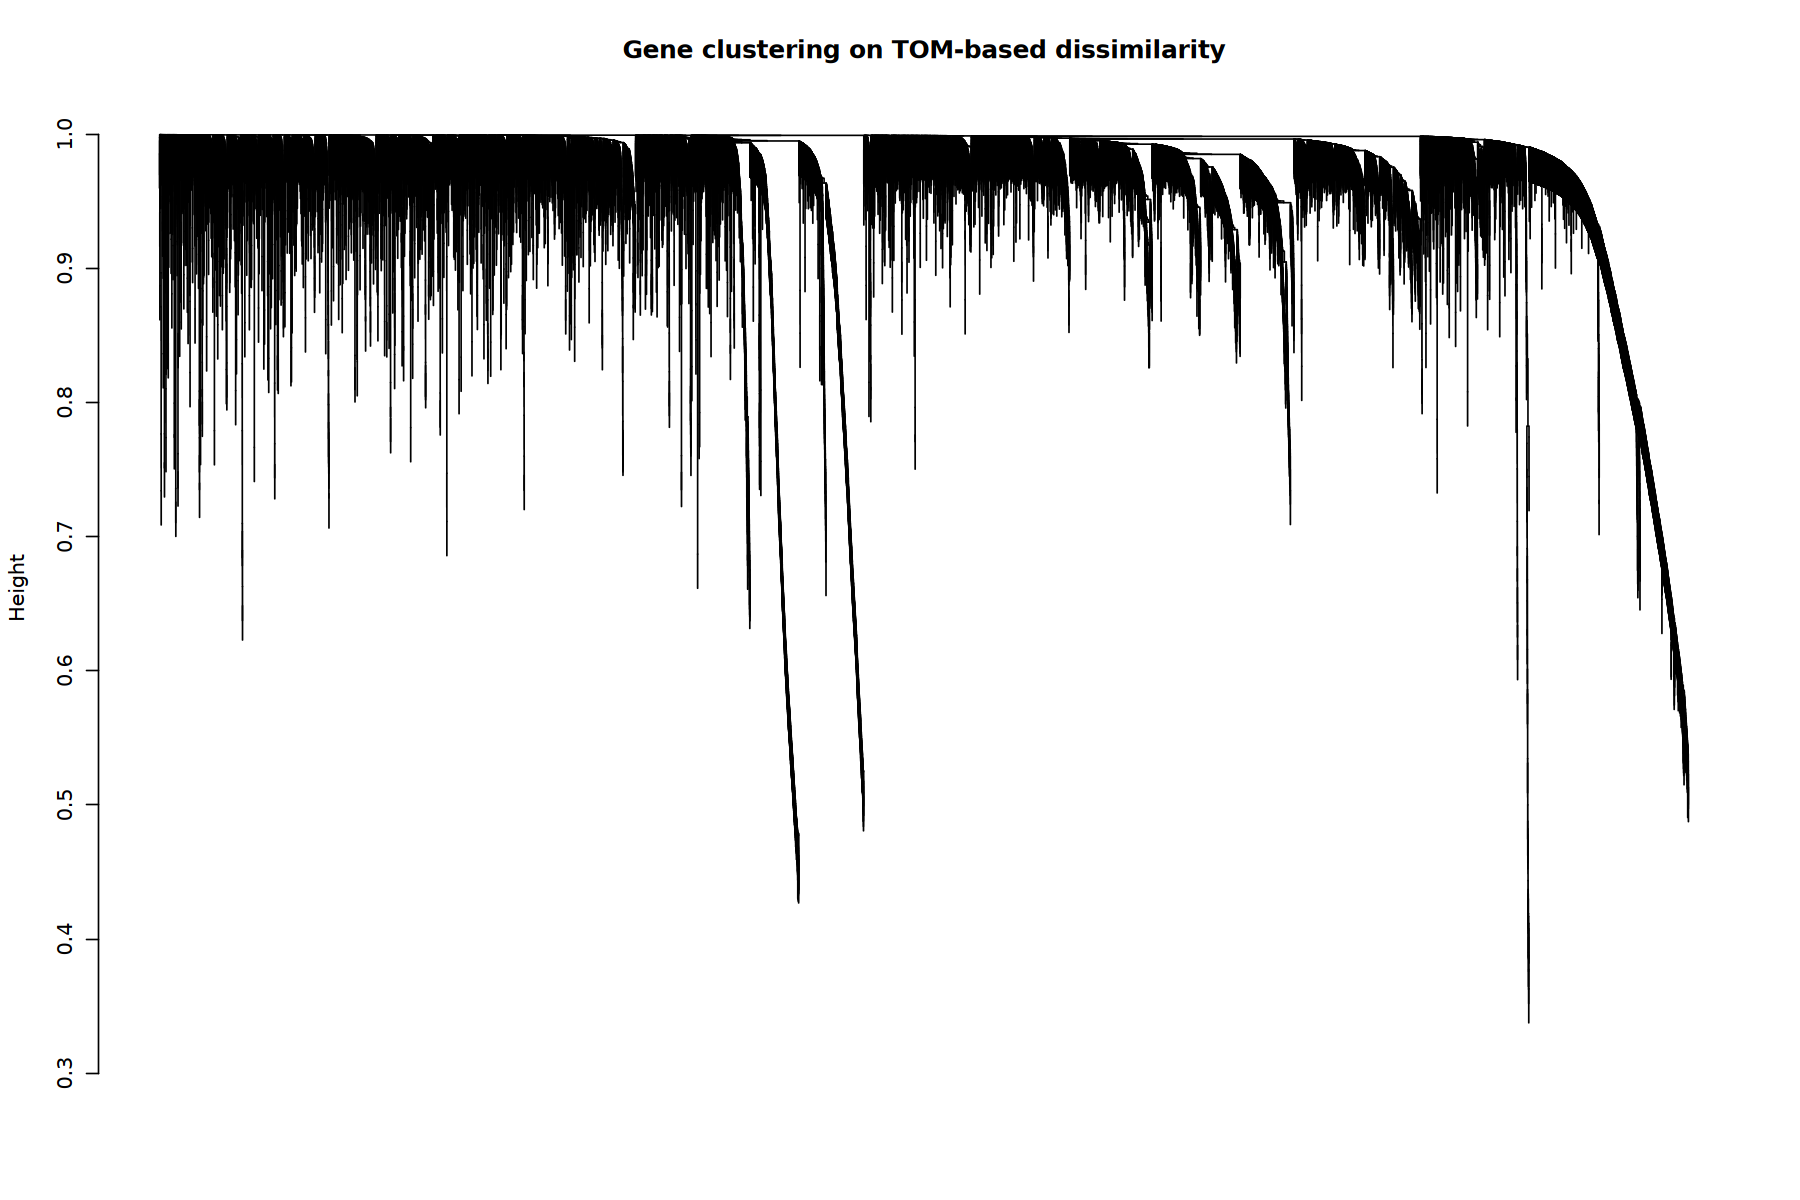

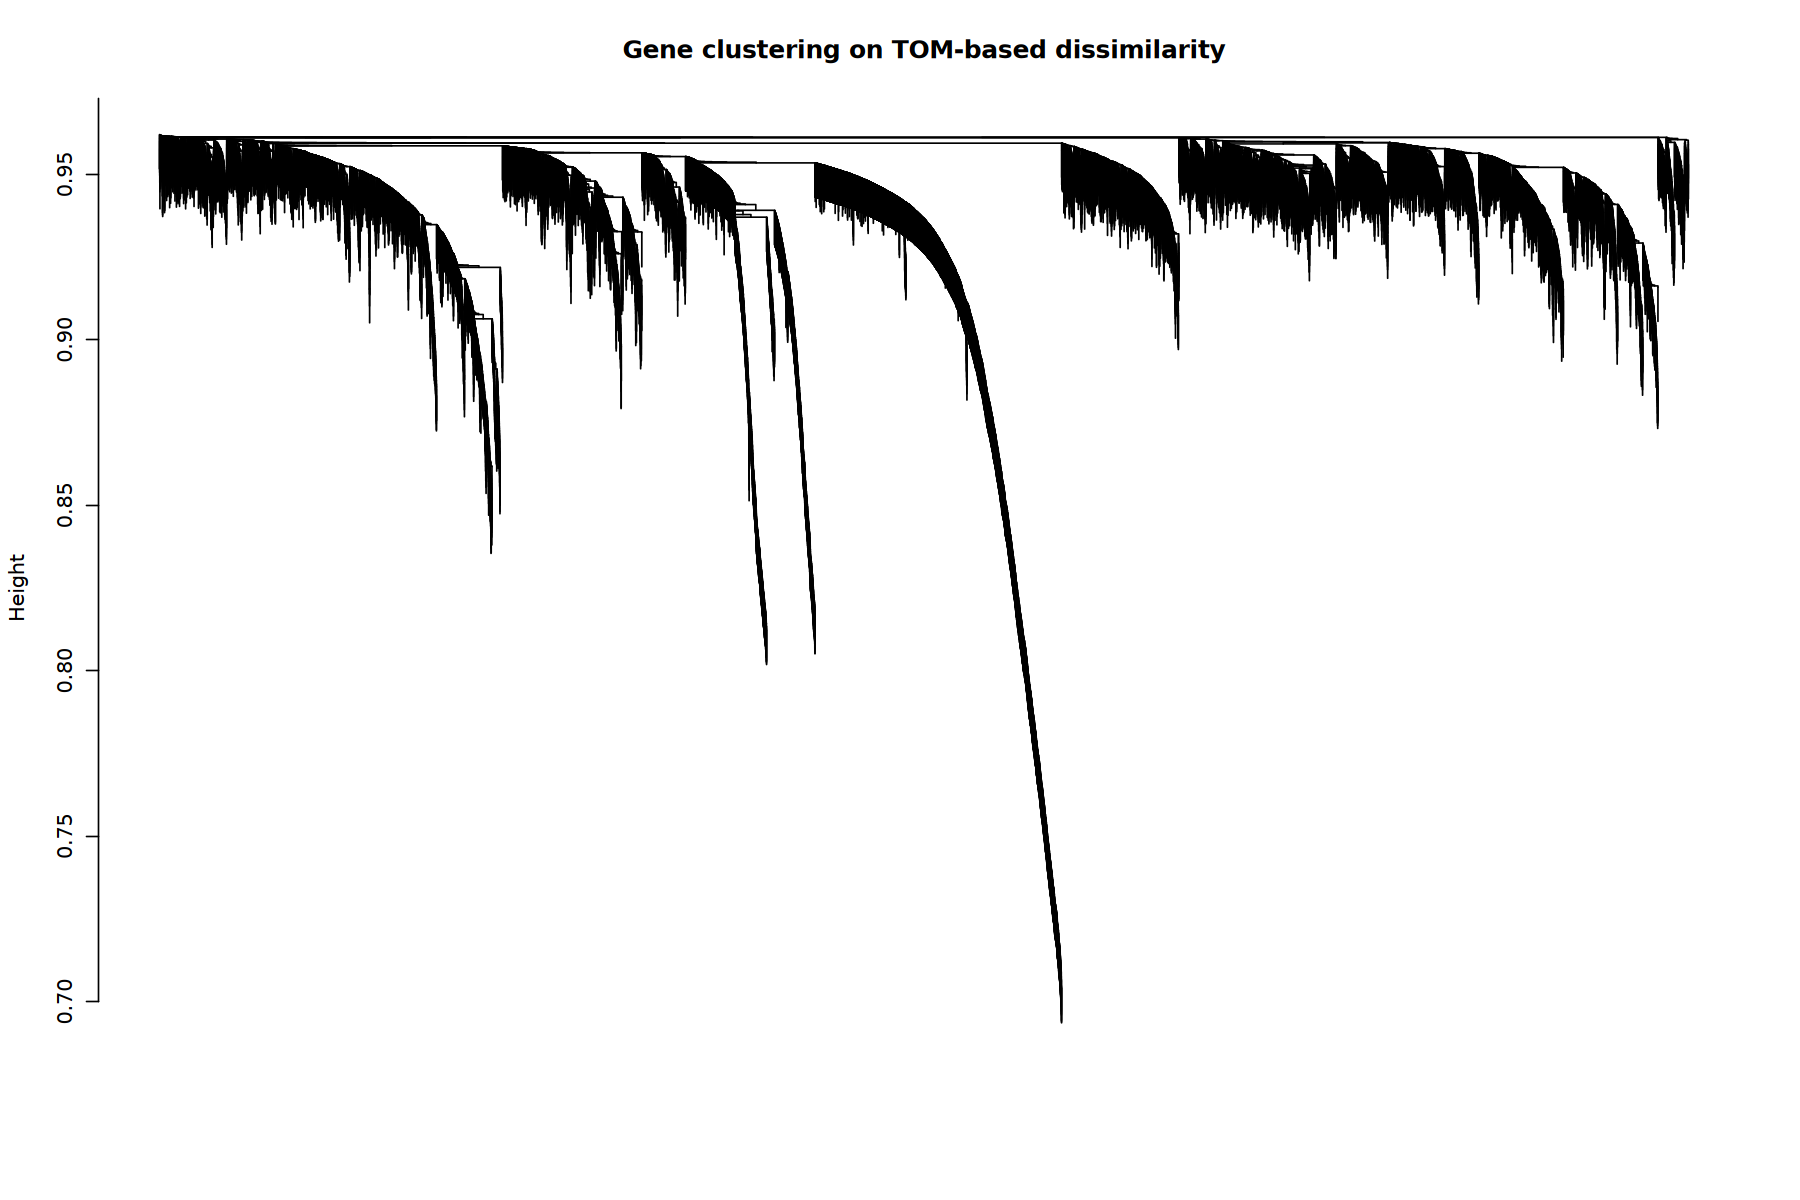

In [20]:
# call hierarchical clustering function
geneTree_unsign = hclust(as.dist(dissTOM_unsign), method = "average")
geneTree_sign = hclust(as.dist(dissTOM_sign), method = "average")

# plot the dendrogram
plot(geneTree_unsign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)
plot(geneTree_sign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

looks like the signed adjacency matrix resulted in more distinct leafs than the unsigned matrix ...

from here on out, I'm going to use the ***signed*** correlation matrix

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [32]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 100

## SIGNED
# Module identification using dynamic tree cut:
dynamicMods_sign <- cutreeDynamic(dendro = geneTree_sign, distM = dissTOM_sign, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods_sign) # number of genes per module

 ..cutHeight not given, setting it to 0.961  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods_sign
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
4323 3879 3321 3210 2037 1975 1677 1629 1100  902  777  544  542  349  282 

15 modules generated

convert numeric network to colors and plots dendrogram:

dynamicColors_sign
       black         blue        brown         cyan        green  greenyellow 
        1677         3879         3321          349         2037          777 
     magenta midnightblue         pink       purple          red       salmon 
        1100          282         1629          902         1975          542 
         tan    turquoise       yellow 
         544         4323         3210 

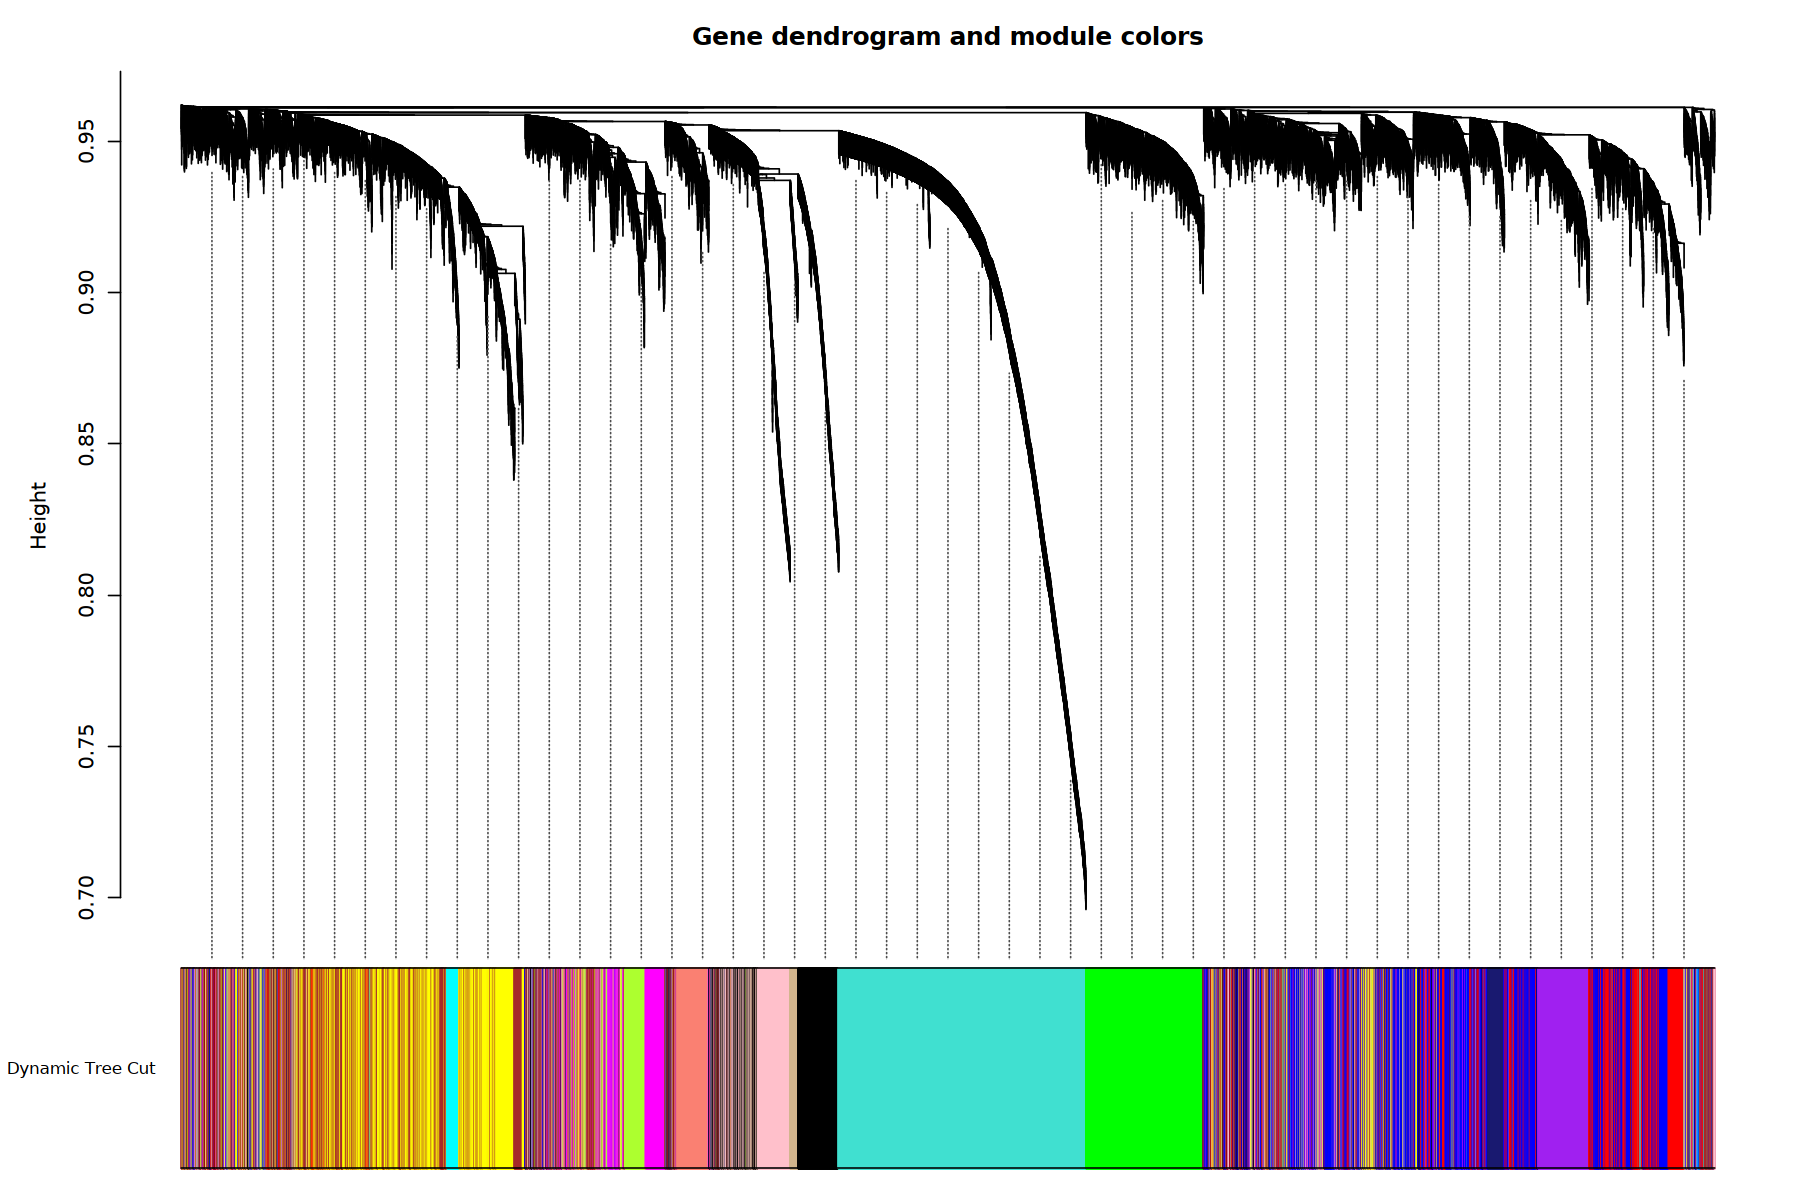

In [33]:
## SIGNED
# Convert numeric lables into colors
dynamicColors_sign <- labels2colors(dynamicMods_sign)
table(dynamicColors_sign)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree_sign, dynamicColors_sign, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")


### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

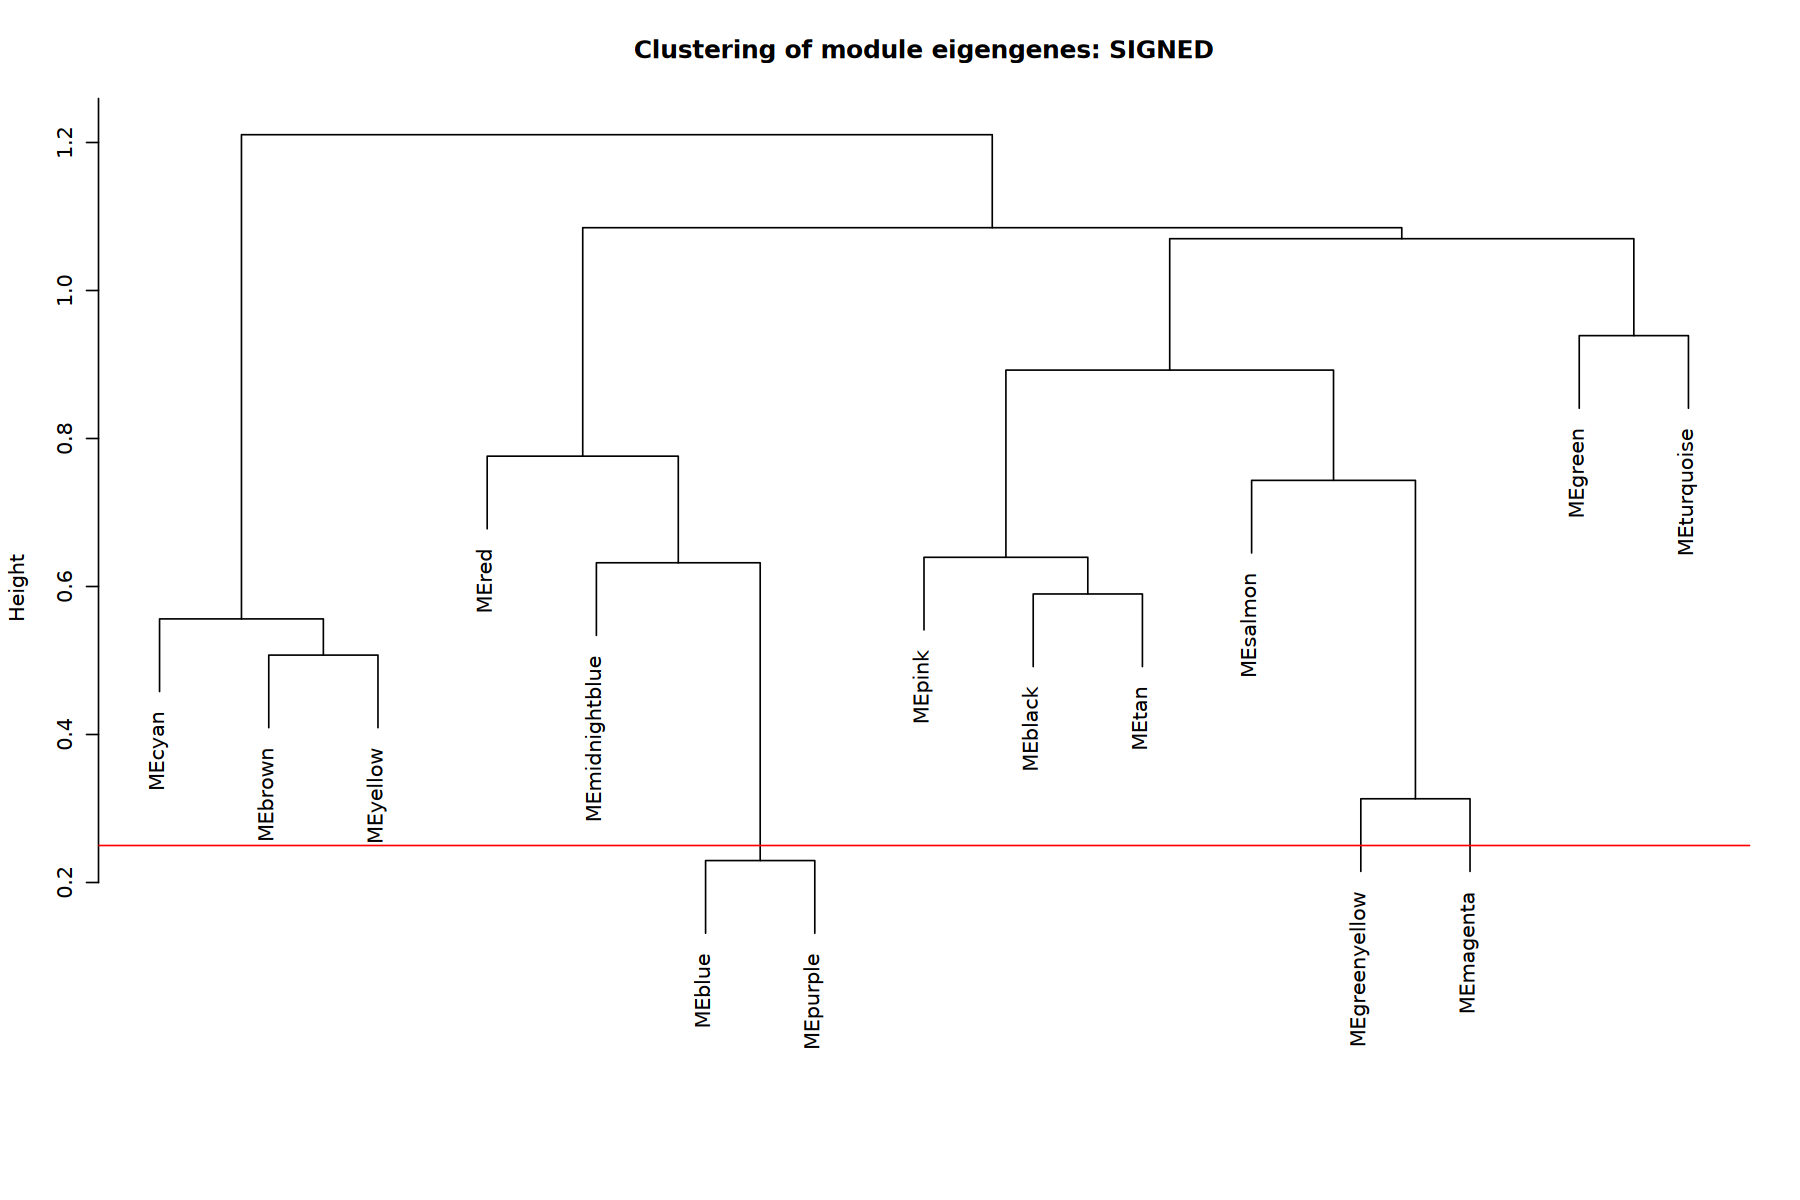

In [34]:
## SIGNED
# Calculate eigengenes
MEList_sign <- moduleEigengenes(dataExpr, colors = dynamicColors_sign)
MEs_sign <- MEList_sign$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss_sign <- 1-cor(MEs_sign)

# Cluster module eigengenes
METree_sign <- hclust(as.dist(MEDiss_sign), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree_sign, main = "Clustering of module eigengenes: SIGNED", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

any branch with more than 75% correlation are related and will be merged - so blue and purple modules will be merged

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 15 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.


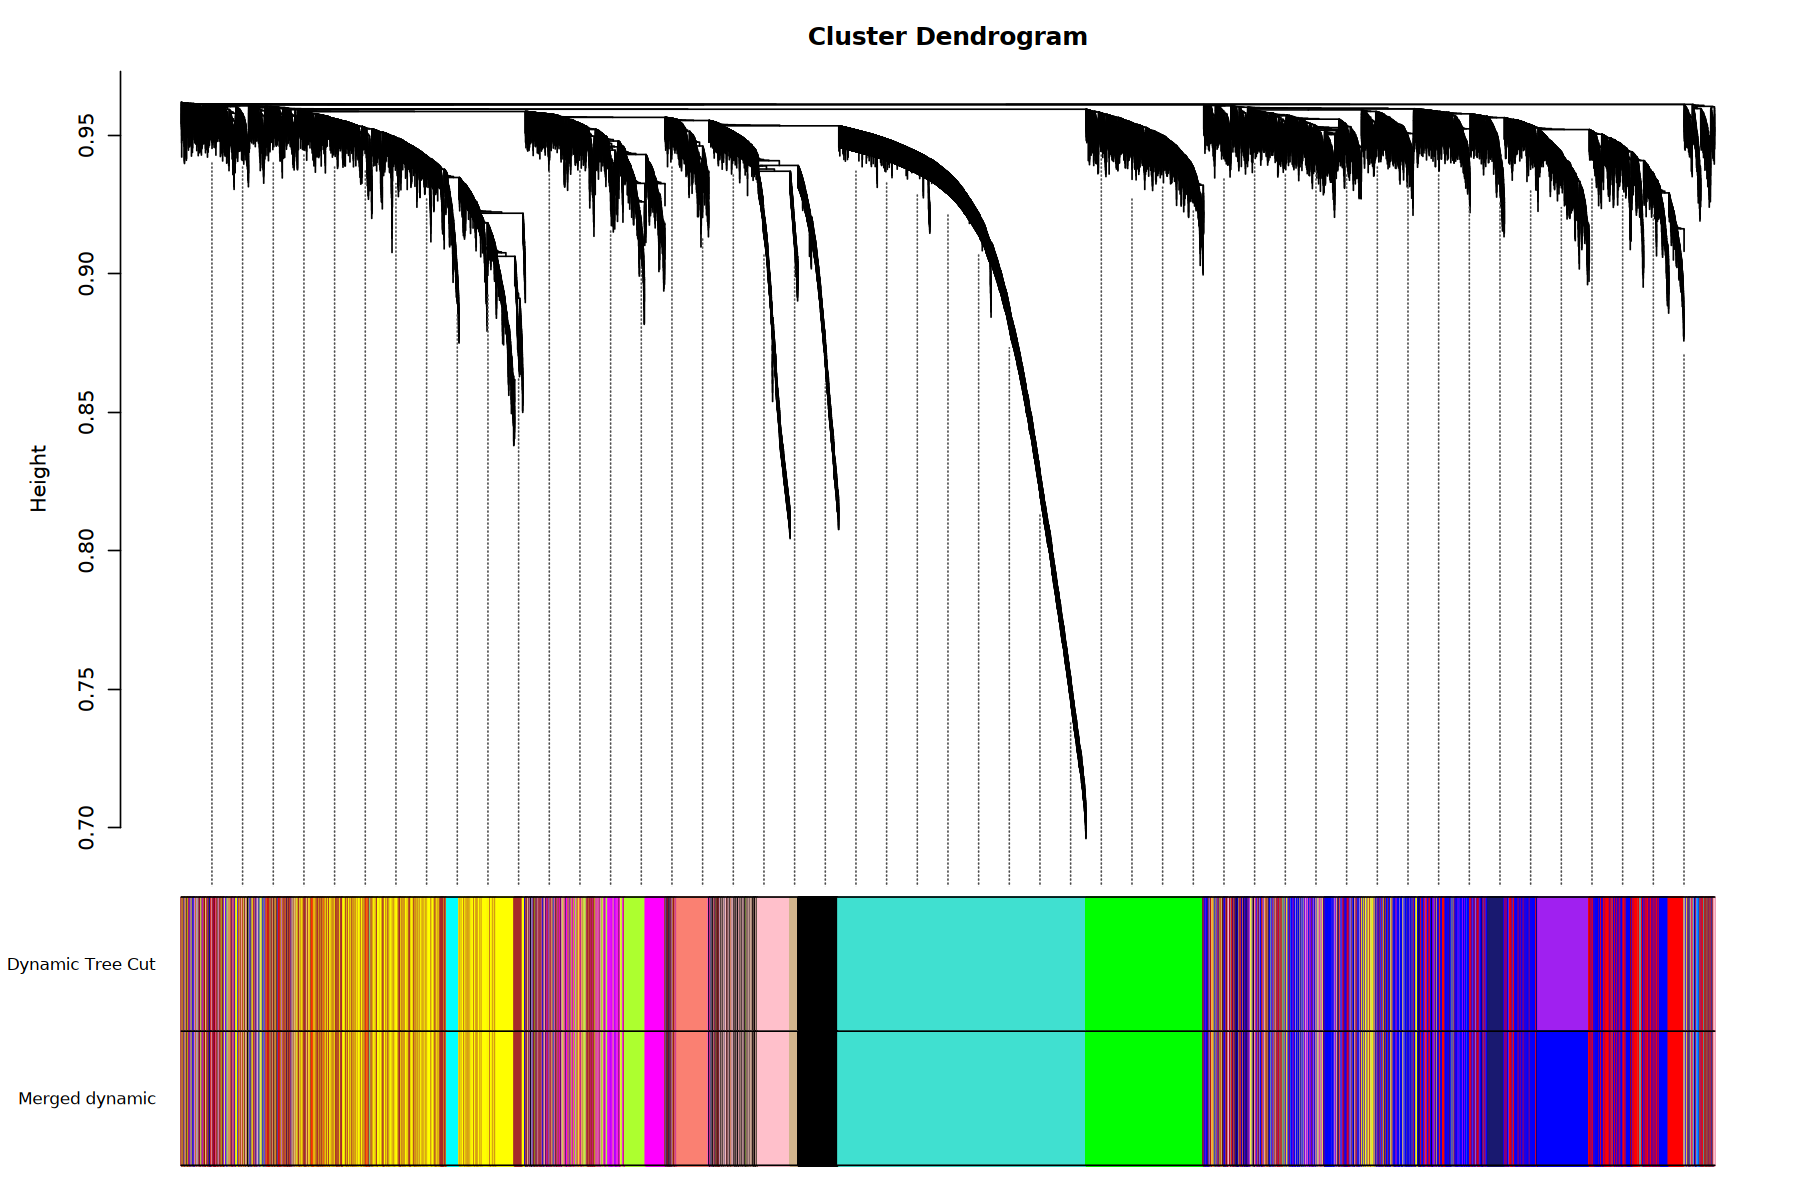

In [35]:
## SIGNED
# Call an automatic merging function
merge_sign <- mergeCloseModules(dataExpr, dynamicColors_sign, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors_sign <- merge_sign$colors

# Eigengenes of the new merged modules:
mergedMEs_sign <- merge_sign$newMEs

# plot merged module colors
plotDendroAndColors(geneTree_sign, cbind(dynamicColors_sign, mergedColors_sign), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

## 3. quantifying module-trait associations
identify modules that are significantly associated with treatment exposures or measured traits (like growth)

## A. read in and format metadata

both treatment metadata and growth data

In [36]:
# read in phase info
dataMeta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv')

# keep only samples seen in dataExpr
dataMeta <- dataMeta[dataMeta$Sample %in% rownames(dataExpr),]

# create combo trtmt column
dataMeta$combo_trtmt <- paste0(dataMeta$Phase1_treatment, '_', dataMeta$Phase2_treatment)

# check it out
dim(dataMeta)
head(dataMeta)


[1] 93 10

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,combo_trtmt
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
1,B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both_both
3,B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both_warm
4,B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5,both_both
5,B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4,both_control
7,B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4,both_both
8,B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3,both_control


values have to be numerical, so going to create a code for my treatments:

#### phase 1 and 2 treatments
1. control
2. warm
3. hypoxic
4. both

#### temperature
1. ambient
2. warm

#### dissolved oxygen
1. normoxic
2. hypoxic

In [37]:
# set factors
dataMeta$Phase1_treatment <- factor(dataMeta$Phase1_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase1_temp <- factor(dataMeta$Phase1_temp, c('ambient', 'warm'))
dataMeta$Phase1_DO <- factor(dataMeta$Phase1_DO, c('normoxic', 'hypoxic'))

dataMeta$Phase2_treatment <- factor(dataMeta$Phase2_treatment, c('control', 'warm', 'hypoxic', 'both'))
dataMeta$Phase2_temp <- factor(dataMeta$Phase2_temp, c('ambient', 'warm'))
dataMeta$Phase2_DO <- factor(dataMeta$Phase2_DO, c('normoxic', 'hypoxic'))

# convert categorical to numerical code for treatment info
### PHASE 1
dataMeta$P1_trtmt_code <- as.numeric(factor(dataMeta$Phase1_treatment))
dataMeta$P1_temp_code <- as.numeric(factor(dataMeta$Phase1_temp))
dataMeta$P1_DO_code <- as.numeric(factor(dataMeta$Phase1_DO))
### PHASE 2
dataMeta$P2_trtmt_code <- as.numeric(factor(dataMeta$Phase2_treatment))
dataMeta$P2_temp_code <- as.numeric(factor(dataMeta$Phase2_temp))
dataMeta$P2_DO_code <- as.numeric(factor(dataMeta$Phase2_DO))

# select only columns needed
metaData <- dataMeta[,-c(2:10)]

# set sample names as rownames
rownames(metaData) <- metaData$Sample
metaData <- metaData %>% select(-Sample)

head(metaData)


,P1_trtmt_code,P1_temp_code,P1_DO_code,P2_trtmt_code,P2_temp_code,P2_DO_code
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B1_B1_O01,4,2,2,4,2,2
B1_W5_O50,4,2,2,2,2,1
B2_B5_O51,4,2,2,4,2,2
B2_C4_O40,4,2,2,1,1,1
B3_B4_O41,4,2,2,4,2,2
B3_C3_O30,4,2,2,1,1,1


could also add growth data to this:

In [38]:
p2_growth <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/growth_phase2.1_weights.csv')

# add leading zeros to single digit tag num
p2_growth$Tag_num <- sprintf("%02d", p2_growth$Tag_num)

# make sample names same as my convention
p1_str <- str_sub(p2_growth$Phase_1_treat, 1, 1)
p2_str <- str_sub(p2_growth$Phase_2_treat, 1, 1)
p2_growth$Sample <- paste0(p1_str, p2_growth$Phase_1_rep, '_', p2_str, p2_growth$Phase_2_rep, '_', p2_growth$Tag_color, p2_growth$Tag_num)
head(p2_growth$Sample)

# pull out growth data for matching samples
p2_growth.df <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df) # 91 samples
dim(metaData) # 93 samples

[1] "B1_B1_O01" "B1_B1_O02" "B1_B2_O13" "B1_B2_O14" "B1_B3_O25" "B1_B3_O26"

[1] 91 33

[1] 93  6

In [39]:
metaData[!rownames(metaData) %in% p2_growth.df$Sample,]

,P1_trtmt_code,P1_temp_code,P1_DO_code,P2_trtmt_code,P2_temp_code,P2_DO_code
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C_W5_W52,1,1,1,2,2,1
W2_B2_G04,2,2,1,4,2,2


i think C_W5_W52 should be **C2_W5_W52** actually and W2_B2_G04 should be **W2_B1_G04**

changing the names in both metaData and dataExpr 

In [40]:
# add missing rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'C_W5_W52'] <- 'C2_W5_W52'
rownames(metaData)[rownames(metaData) == 'C_W5_W52'] <- 'C2_W5_W52'

# fix wrong rep number to sample name
rownames(dataExpr)[rownames(dataExpr) == 'W2_B2_G04'] <- 'W2_B1_G04'
rownames(metaData)[rownames(metaData) == 'W2_B2_G04'] <- 'W2_B1_G04'

pulling out the growth data now - should be the same number of samples ...

In [41]:
# pull out growth data for matching samples
p2_growth.df2 <- p2_growth[p2_growth$Sample %in% rownames(metaData), ]

# check it out
dim(p2_growth.df2) # 93 samples
dim(metaData) # 93 samples


[1] 93 33

[1] 93  6

so all good now with matching sample names!

now pulling out only the growth columns and merging with the other meta data df 

In [42]:
# select growth columns
p2_growth.df2 <- p2_growth.df2 %>%
select(Sample, Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg)

# sample is the rowname
rownames(p2_growth.df2) <- p2_growth.df2$Sample
p2_growth.df2 <- p2_growth.df2 %>% select(-Sample)


head(p2_growth.df2)

,Actual_shell_growth_mg,Actual_tissue_growth_mg,Ratio_tissue_shell_mg
,<dbl>,<dbl>,<chr>
B1_B1_O01,210.2755,120.72448,0.574125224
B1_W5_O50,315.8883,85.61170,0.271018901
B2_B5_O51,114.3215,44.47852,0.389065292
B2_C4_O40,164.9903,55.10972,0.33401798
B3_B4_O41,197.9250,116.17500,0.586964759
B3_C3_O30,316.0466,241.35336,0.763663743


In [43]:
# merge dfs
metaData_merge <- merge(p2_growth.df2, metaData, by = 'row.names')

# set samples as rownames
metaData_merge <- metaData_merge %>% 
column_to_rownames(var = 'Row.names')

head(metaData_merge)

,Actual_shell_growth_mg,Actual_tissue_growth_mg,Ratio_tissue_shell_mg,P1_trtmt_code,P1_temp_code,P1_DO_code,P2_trtmt_code,P2_temp_code,P2_DO_code
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B1_B1_O01,210.2755,120.72448,0.574125224,4,2,2,4,2,2
B1_W5_O50,315.8883,85.61170,0.271018901,4,2,2,2,2,1
B2_B5_O51,114.3215,44.47852,0.389065292,4,2,2,4,2,2
B2_C4_O40,164.9903,55.10972,0.33401798,4,2,2,1,1,1
B3_B4_O41,197.9250,116.17500,0.586964759,4,2,2,4,2,2
B3_C3_O30,316.0466,241.35336,0.763663743,4,2,2,1,1,1


In [44]:
# define # of genes and samples
nSamples <- nrow(dataExpr)
nGenes <- ncol(dataExpr)

eigengene ~ summary profile of the module

now can correlate eigengenes with external traits and look for most significant associations

In [45]:
# reorder columns
metaData_merge <- metaData_merge %>%
select(Actual_shell_growth_mg, Actual_tissue_growth_mg, Ratio_tissue_shell_mg, P1_trtmt_code, P2_trtmt_code, P1_temp_code, P2_temp_code, P1_DO_code, P2_DO_code)

head(metaData_merge)

,Actual_shell_growth_mg,Actual_tissue_growth_mg,Ratio_tissue_shell_mg,P1_trtmt_code,P2_trtmt_code,P1_temp_code,P2_temp_code,P1_DO_code,P2_DO_code
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B1_B1_O01,210.2755,120.72448,0.574125224,4,4,2,2,2,2
B1_W5_O50,315.8883,85.61170,0.271018901,4,2,2,2,2,1
B2_B5_O51,114.3215,44.47852,0.389065292,4,4,2,2,2,2
B2_C4_O40,164.9903,55.10972,0.33401798,4,1,2,1,2,1
B3_B4_O41,197.9250,116.17500,0.586964759,4,4,2,2,2,2
B3_C3_O30,316.0466,241.35336,0.763663743,4,1,2,1,2,1


growth meaning the growth from the beginning of phase 2 to the end of phase 2 - we do not have data on these oysters' growth before and after phase 1. The ratio of tissue to shell growth is a proxy for fitness (more tissue = investing in reproduction, more shell = investing in defense)

In [48]:
# Recalculate MEs (module eigengenes) with color labels

MEs0 <- moduleEigengenes(dataExpr, mergedColors_sign)$eigengenes # create module eigengenes

MEs <- orderMEs(MEs0) # order so more similar modules are closer together

moduleTraitCor <- cor(MEs, metaData_merge, use = "p") # correlate with traits - using Pearson correlations

moduleTraitPvalue <- corPvalueStudent(moduleTraitCor, nSamples) # compute p-values - uses student's t-distribution

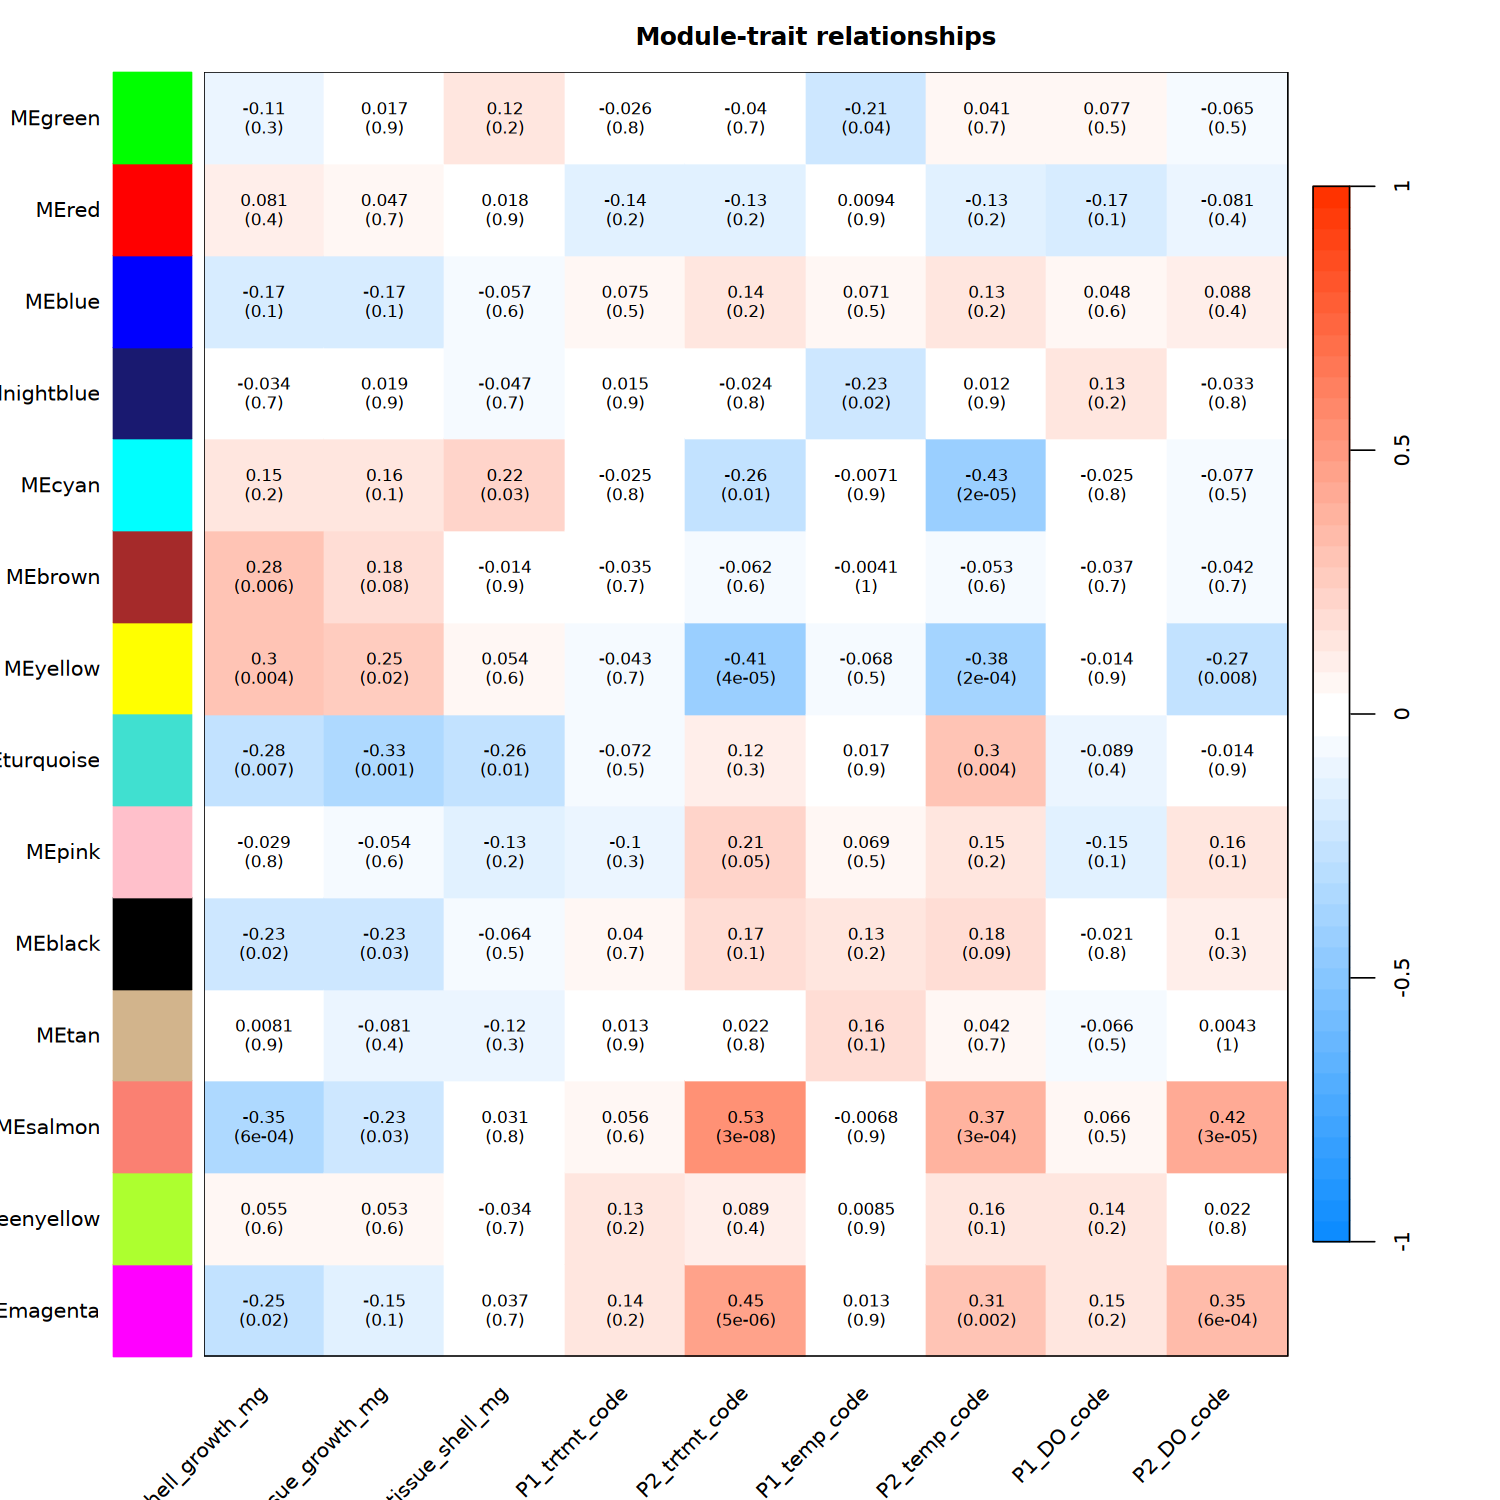

In [49]:
options(repr.plot.width = 12.5, repr.plot.height = 12.5)

# Will display correlations and their p-values
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor, 
               xLabels = names(metaData_merge), 
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.8,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

each row corresponds to a module eigengene, column to a treatment

each cell contains the corresponding correlation and p-value and the table is colored by correlation (in my case, I've assigned numerical codes to categorical treatments, with the control/normoxic/ambient treatment always being 1)

red cells indicate positive correlation, blue cells a negative correlation - looking for dark cells with significant pvalues to identify module of interest

**specifically looking for...**:
- modules with opposing relationships between phase 1 and phase 2 (whether that's DO, temp, or treatment altogether; can also be growth as in red for tissue but blue for shell)
- modules with significant relationships (number within the paratheses)

**observations**:
- none of the modules have a significant relationship with p1_treatment or p1_DO, which makes sense since these samples were taken after p2 and we expect most GE to be short-term
    - there are 5 modules with a sig. relationship with p2_treatment (three red and two blue)
- there are 3 modules with a sig. relationship with a DO treatment (cols 8 and 9) and 7 modules with a significant relationship with a temp treatment (cols 6 and 7)
- there are a few modules with sig. relationships with tissue/shell growth, and they're in the same direction for tissue and shell
    - only 2 modules with a sig. relationship with the ratio of tissue to shell growth, one pos. and one neg.

based on this, **potentially interesting modules include**:
- for **P2_trtmt_code**: MEsalmon, MEmagent, MEyellow
- for **Actual_shell_growth_mg**: MEbrown, MEsalmon, MEturquoise
- for **Actual_tissue_growth_mg**: MEturquoise
- for **P1_Temp_code**: MEmidnightblue
- for **P2_Temp_code**: MEyellow, MEsalmon, MEcyan
- for **P2_DO_code**: MEyellow, MEsalmon, MEmagenta



### ggplot

In [110]:
# Create ME table
MEs_df <- as.data.frame(MEs)
MEs_df$Sample <- rownames(MEs_df)

# format metadata and merge with MEs
metaData_merge$Sample <- rownames(metaData_merge)
dataMeta2 <- dataMeta[,1:10]
meta_merge <- merge(dataMeta2, metaData_merge[,c(1,2,3,10)], by = 'Sample')

# Melt to long format
MEsPlotting_melt <- reshape2::melt(
  MEsPlotting,
  id.vars = c("Sample",
              "Phase1_treatment",
              "Phase1_temp",
              "Phase1_DO",
              "Phase1_TankRep",
              "Phase2_treatment",
              "Phase2_temp",
              "Phase2_DO",
              "Phase2_TankRep",
              "combo_trtmt",
              'Actual_shell_growth_mg',
              'Actual_tissue_growth_mg', 
              'Ratio_tissue_shell_mg'
             ),
  variable.name = "Module",
  value.name = "Eigengene"
)

MEsPlotting_melt <- MEsPlotting_melt %>%
filter(!grepl('code', Module)) # remove treatment code rows

head(MEsPlotting_melt)

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,combo_trtmt,Actual_shell_growth_mg,Actual_tissue_growth_mg,Ratio_tissue_shell_mg,Module,Eigengene
,<I<chr>>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<dbl>
1,B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both_both,210.2755,120.72448,0.574125224,MEgreen,-0.07267705
2,B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both_warm,315.8883,85.61170,0.271018901,MEgreen,0.11259458
3,B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5,both_both,114.3215,44.47852,0.389065292,MEgreen,-0.08984971
4,B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4,both_control,164.9903,55.10972,0.33401798,MEgreen,0.10140997
5,B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4,both_both,197.9250,116.17500,0.586964759,MEgreen,0.09981873
6,B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3,both_control,316.0466,241.35336,0.763663743,MEgreen,0.13421227


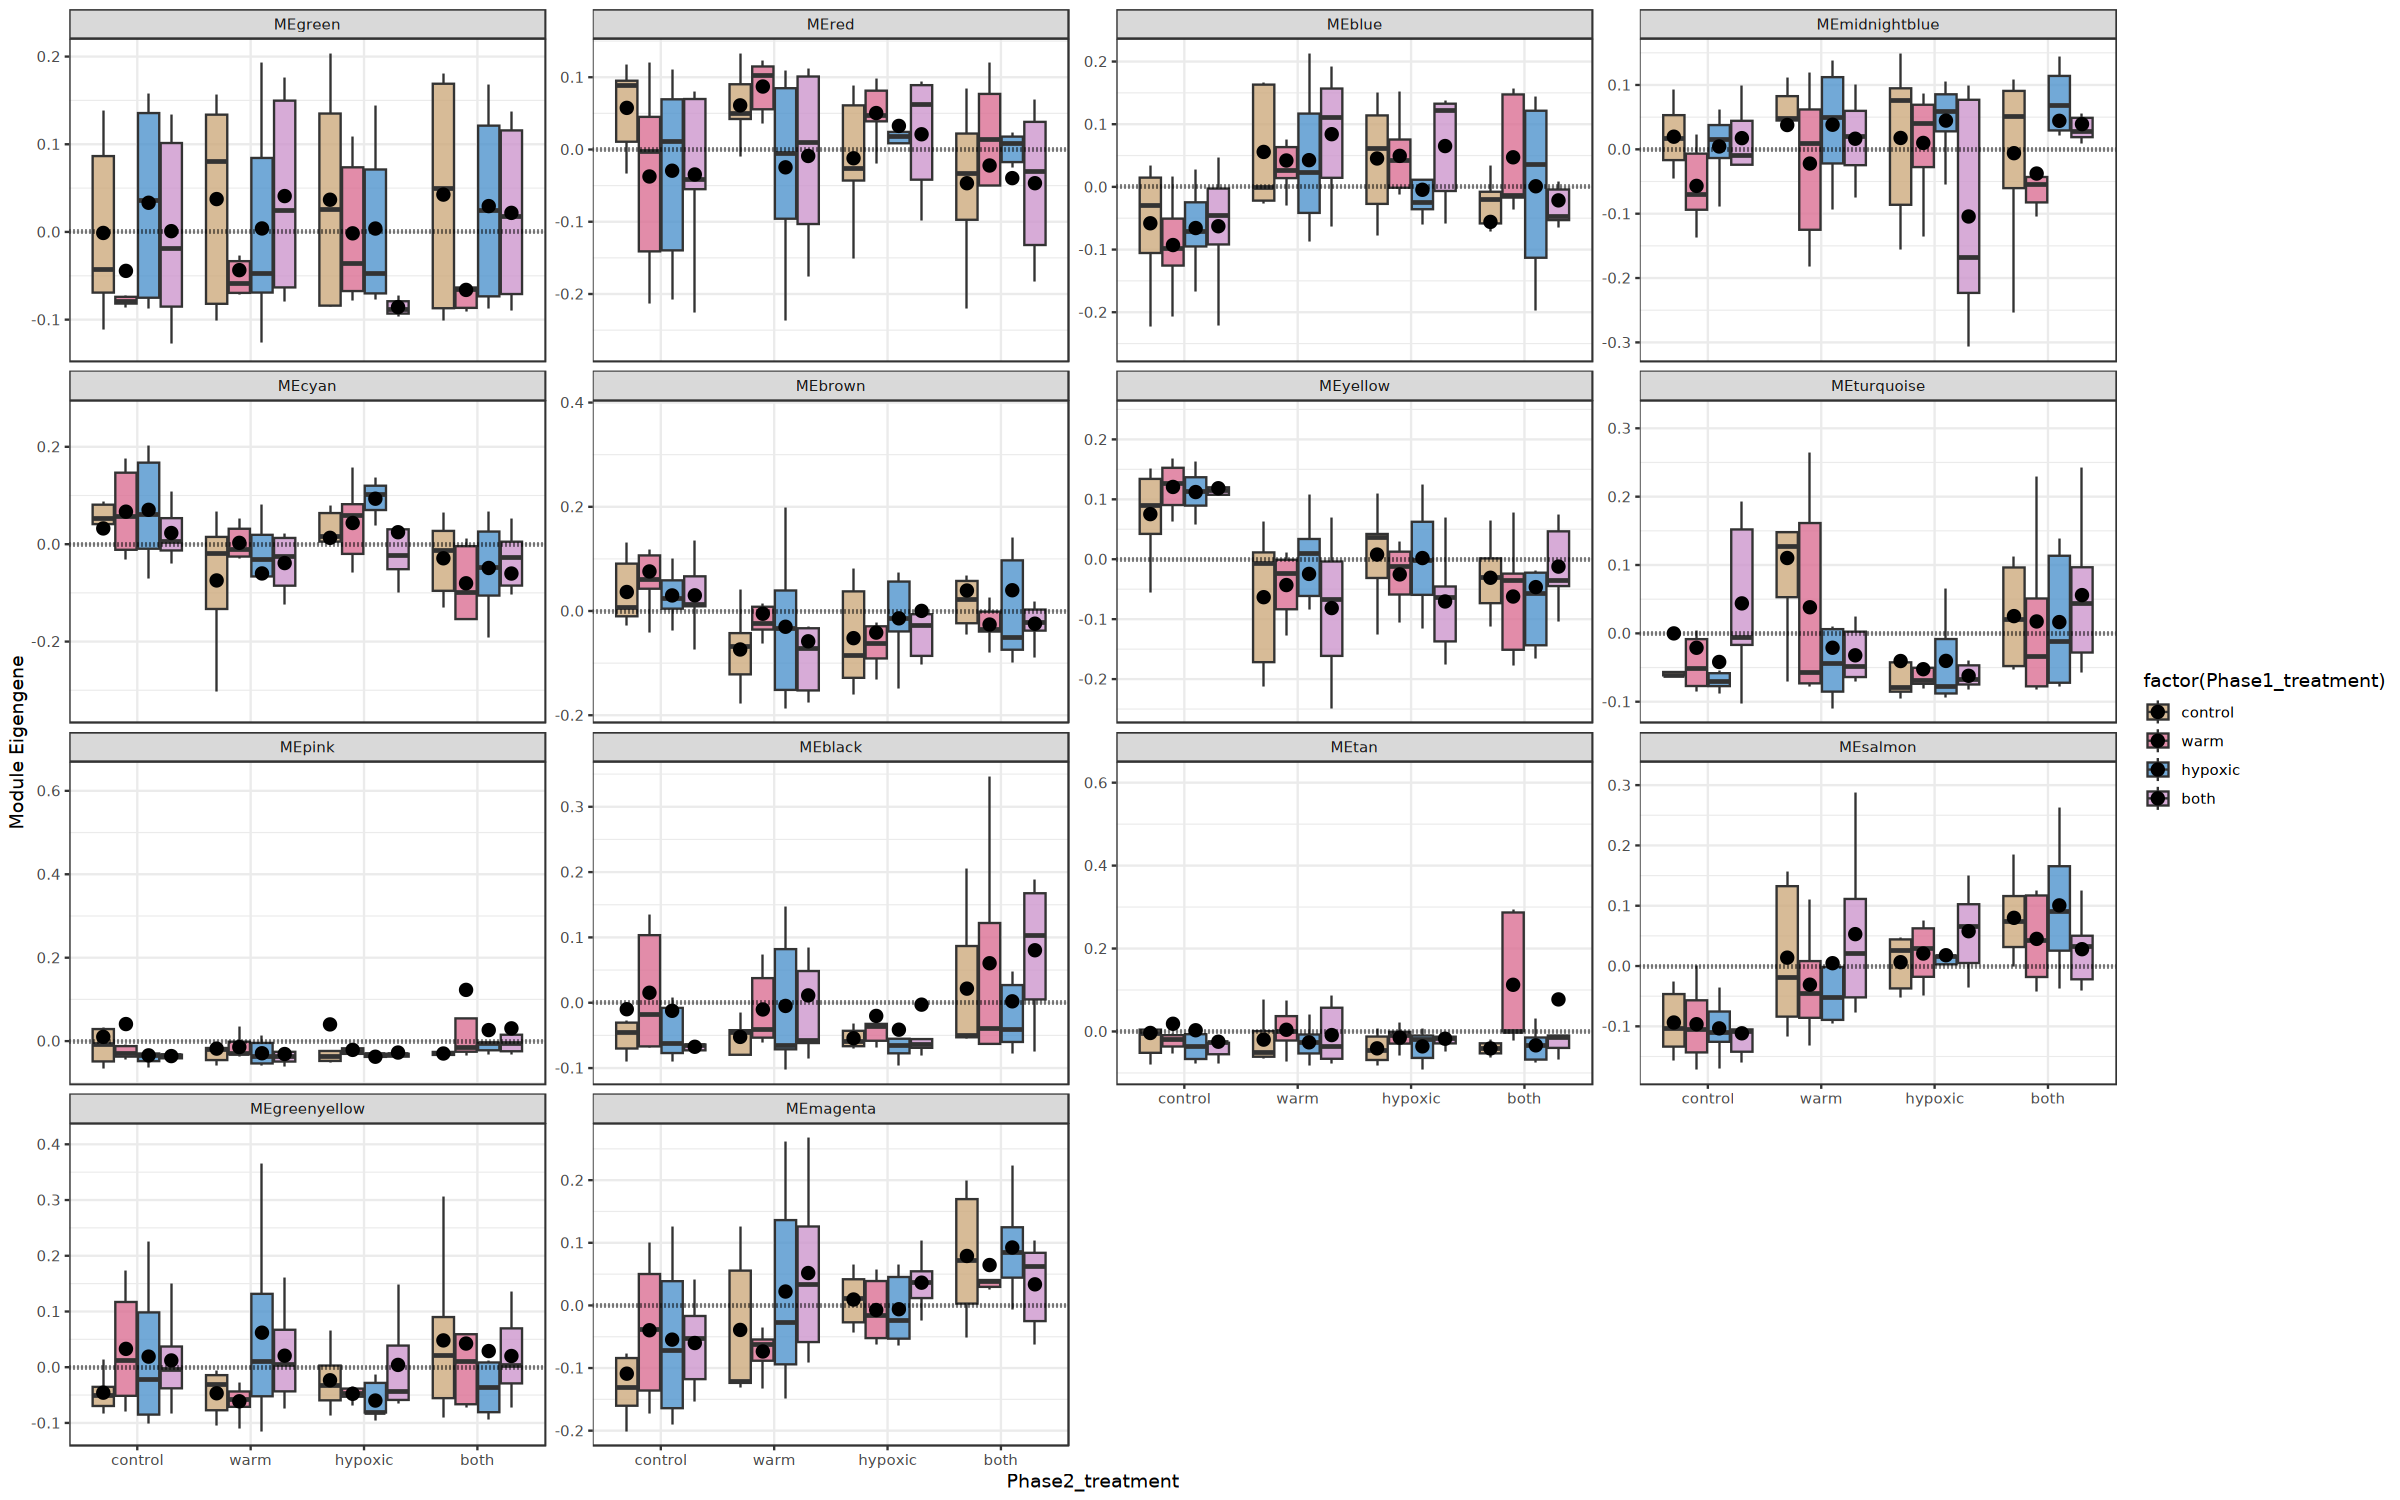

In [114]:
options(repr.plot.width = 20, repr.plot.hieght = 20)

ggplot(MEsPlotting_melt,
       aes(x = Phase2_treatment,
           y = Eigengene,
           fill = factor(Phase1_treatment))) +
  
  geom_boxplot(position = position_dodge(0.8),
               outlier.shape = NA,
               alpha = 0.8) +

scale_fill_manual(values = c("hypoxic" = "steelblue3", 
                             "warm" = "palevioletred", 
                             "control" = "burlywood3", 
                             "both" = "plum3")) +
  
  stat_summary(fun = mean,
               geom = "point",
               color = "black",
               position = position_dodge(0.8),
               size = 3) +
  
  geom_hline(yintercept = 0,
             linetype = "dotted",
             linewidth = 1) +
  
  ylab("Module Eigengene") +
  theme_bw() +
  facet_wrap(~ Module, scales = "free_y")


### H. Gene significance and module membership
quantify associations of individual genes with trait of interest by defining gene significance (GS) as the abs. value of the correlation between the gene and the trait 

also define quantitative measure of module membership (MM) as the correlation of module eigengene and gene expression profile

basically select a module of interest and validate with GS and MM - allows quantification of the similarity of all genes on the array to every module

In [ ]:
# remove ME before module names
modNames <- substring(names(MEs), 3)
modNames

In [ ]:
# define variable P2_trtmt_code containing the trtmt code col in metaData_merge
P2_trtmt_code <- as.data.frame(metaData_merge$P2_trtmt_code)
names(P2_trtmt_code) <- 'P2_trtmt_code'

geneModuleMembership <- as.data.frame(cor(dataExpr, MEs, use = 'p'))
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) <- paste('MM', modNames, sep = '')
names(MMPvalue) <- paste('p.MM', modNames, sep = '')

geneTraitSignificance <- as.data.frame(cor(dataExpr, P2_trtmt_code, use = 'p'))
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))

names(geneTraitSignificance) <- paste('GS.', names(P2_trtmt_code), sep = '')
names(GSPvalue) <- paste('p.GS', names(P2_trtmt_code), sep = '')

In [ ]:
module <- 'brown'
column <- match(module, modNames)
moduleGenes <- moduleColors == module

verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance[moduleGenes, 1]),
                   xlab = paste('Module Membership in:', module, 'module'),
                   ylab = 'Gene significance for Phase 2 Treatment',
                   main = paste('Module membership vs. gene significance\n'),
                   cex.main = 1.2, cex.lab = 1.2, cez.axis = 1.2, col = module)

somewhat negative relationship, not super strong